# Grupowanie hierarchiczne

W tym zadaniu zapoznamy się z inną metodą klasteryzacji, czyli grupowaniem hierarchicznym. Możemy zastosować jedno z dwóch podejść: metodę aglomeracyjną lub deaglomeracyjną.

Metoda aglomeracyjna polega na tym, że początkowo każdy obiekt tworzy osobny klaster (skupienie). Następnie dwa najbliższe skupienia (w wybranej metryce odległości) scalane są w jedno i taka operacja jest powtarzana do momentu, aż powstanie jedno duże skupienie zawierające wszystkie dane. 

Metoda deaglomeracyjna polega na odwrotnym postępowaniu - najpierw wszystkie obiekty znajdują się w jednym skupieniu, a następnie dzielimy je na mniejsze zawierające najbardziej podobne do siebie obiekty, aż dojdziemy do momentu, gdy w każdym skupieniu znajduje się tylko jeden obiekt.

Będziemy pracować na tych samych danych, co w poprzednim zadaniu - wczytamy je z zapisanych plików.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

Przed przystąpieniem do grupowania musimy ustandaryzować dane - tym razem nie będziemy tworzyć nowej tabeli, tylko nadpiszemy wczytane dane.

In [2]:
all_data_df = pd.read_csv('all_data.csv')
# usuwamy kolumnę z etykietami numerycznymi - nie będzie nam potrzebna:
all_data_df = all_data_df.drop(columns='genre_numeric_label')
feats_names = np.loadtxt('features_list.txt', dtype=str)

scaled_feats = StandardScaler().fit_transform(all_data_df[feats_names])
all_data_df[feats_names] = scaled_feats

## Metryki i miary odległości

Do grupowania hierarchicznego wykorzystywane jest pojęcie odległości w przestrzeni metrycznej, czyli metryki (Definicja D6 i Przykład D1 w skrypcie przedmiotowym, str. 149) - jest to sposób, w jaki definiujemy odległość między dwoma punktami (obserwacjami). Najczęściej korzystamy z metryki euklidesowej, za pomocą której wyznaczamy np. długość odcinka AB na płaszczyźnie, ale możemy zdefiniować także inne sposoby wyznaczania odległości - np. jako najkrótszą trasę między dwoma punktami. Do częściej używanych metryk należą: maksimowa (maksimum), taksówkowa (Manhattan), kątowa (zamiast niej często stosuje się tzw. odległość kosinusową, *cosine similarity*, która nie spełnia jednak warunków metryki).

Możemy też zastosować różne metody oceny odległości, na podstawie których podejmujemy decyzję o połączeniu lub rozdzieleniu skupień (opisane w skrypcie, rozdz. 11.1 lub [w dokumentacji sklearn](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering)): 
- pojedyncze połączenie (*single linkage*, metoda najbliższego sąsiada),
- całkowite połączenie (*complete linkage*, metoda najdalszego sąsiada),
- średnia odległość (*average distance*),
- algorytm Warda, minimalizujący wariancję skupień.

## Przykład - grupowanie

Zobaczmy, jak metoda grupowania aglomeracyjnego podzieli nasze dane na zbiory. Skorzystamy z klasy [AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) (`from sklearn.cluster import AgglomerativeClustering`) w sklearn. Użyjemy metryki euklidesowej (`metric='euclidean'`) i tworzenia skupień kryterium Warda (`linkage='ward'`). Możemy także ustalić, ile skupień chcemy uzyskać (`n_clusters`) lub jaka jest minimalna odległość, przy której kończymy grupowanie (`distance_threshold`). Zastosujemy ten drugi parametr, ustawiając go na 0 - czyli wychodzimy od sytuacji, kiedy każdy utwór jest osobnym elementem.

In [3]:
clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None, metric='euclidean', linkage='ward')
#distance_threshold=0, n_clusters=None zapewniają podział do momentu, aż w każdym skupieniu będzie znajdował się tylko 1 obiekt
#metric - metryka, która będzie użyta do obliczenia odległości między obiektami
#linkage - metoda tworzenia skupień

clustering.fit(all_data_df[feats_names]) # przeprowadzamy grupowanie na naszych danych - moglibyśmy także podać macierz obliczonych odległości, jesli np. korzystamy z metryki niedostępnej w algorytmie

,n_clusters,None
,metric,'euclidean'
,memory,None
,connectivity,None
,compute_full_tree,'auto'
,linkage,'ward'
,distance_threshold,0
,compute_distances,False


Wyświetlmy liczbę skupień: jest równa liczbie obserwacji (*samples*) w naszej tabeli, czego się spodziewaliśmy, ustawiając `distance_threshold=0`.

In [4]:
clustering.n_clusters_

9055

## Dendrogram
Wynik grupowania hierarchicznego przedstawia się w postaci tzw. dendrogramu - wykresu, który przedstawia hierarchię skupień. Do jego narysowania użyjemy funkcji [dendrogram](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py) (`from scipy.cluster.hierarchy import dendrogram`) oraz wrappera z dokumentacji biblioteki scikit-learn.

Funkcja rysująca dendrogram przyjmuje macierz połączeń, którą musimy utworzyć na podstawie drzewa zwróconego przez AgglomerativeClustering. Skorzystamy z [przykładu w dokumentacji](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py), aby to zrobić.

(Wyjaśnienie, dlaczego w taki sposób zliczamy skupienia, można znaleźć [np. tutaj](https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/#Perform-the-Hierarchical-Clustering))

In [5]:
def plot_dendrogram(model, **kwargs):
    # kwargs to słownik argumentów, które przekażemy do funkcji dendrogram

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    # zliczanie obiektów w poszczególnych skupieniach
    for i, merge in enumerate(model.children_): # przechodzimy przez całe drzewo połączeń
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # liść - leaf node - czyli węzeł bez dzieci
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    
    # tworzenie macierzy połączeń
    linkage_matrix = np.column_stack([model.children_,
                                      model.distances_,
                                      counts]).astype(float)
    # rysowanie dendrogramu
    dendrogram(linkage_matrix, **kwargs)

Przy dużej liczbie skupień (pamiętajmy, że mamy ich prawie 10k, bo schodziliśmy do pojedynczych liści), wyświetlenie całego dendrogramu będzie mało czytelne - możemy go „przyciąć” do wybranej wysokości. W tym celu wybieramy liczbę poziomów `p`, które chcemy przedstawić na wykresie (licząc od góry, czyli od największego skupienia) oraz podajemy `truncate_mode='level'`.

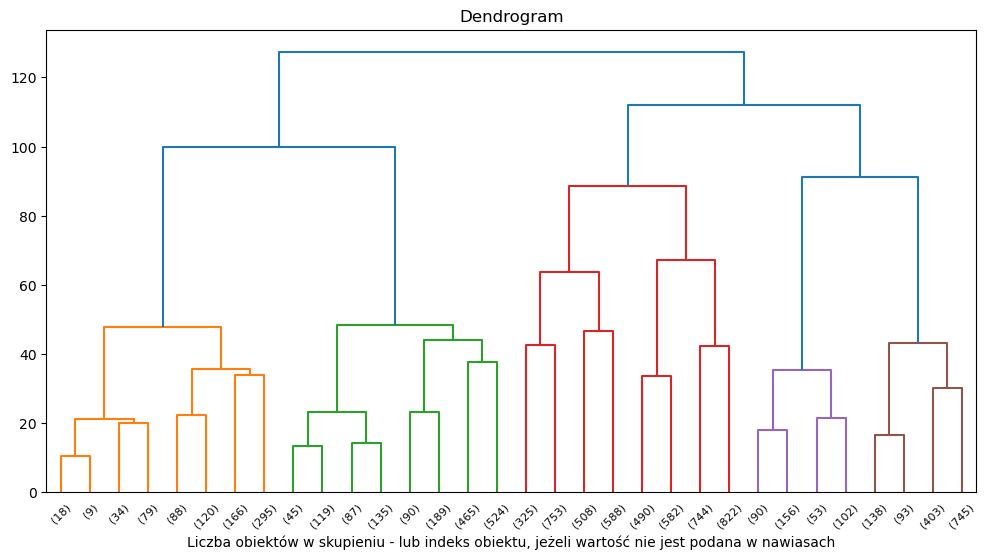

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))  

# wyświetlimy trzy poziomy dendrogramu
plot_dendrogram(clustering, ax=ax, truncate_mode='level', p=4, labels=all_data_df['genre_top']) 
#p - liczba poziomów, na które będą podzielone dane na wyświetlanym wykresie
# labels - etykiety obiektów (jeśli pojedyncze elementy znajdą się na wykresie)

ax.set_title('Dendrogram')
ax.set_xlabel('Liczba obiektów w skupieniu - lub indeks obiektu, jeżeli wartość nie jest podana w nawiasach')
plt.show()

Dendrogram pokazuje nam liczebność poszczególnych grup, ich skład i hierarchiczność - tworzące się podzbiory klas. Prześledzenie macierzy połączeń pozwala dowiedzieć się, w jakiej kolejności obiekty były łączone. Nie dowiemy się jednak, które cechy zadecydowały o przyporządkowaniu.

Długość każdej gałęzi informuje o odległości między węzłami, które ona łączy.

## Przyporządkowanie do skupień

Metoda aglomeracyjna może też zwrócić przyporządkowanie do skupień. Ustalmy teraz liczbę skupień na 8 (tyle mieliśmy gatunków w obrobionym zbiorze danych) i sprawdźmy przyporządkowanie. Dodamy jego wynik do naszej tabeli:

In [7]:
model = AgglomerativeClustering(n_clusters=8, metric='euclidean', linkage='ward')

clusters = model.fit_predict(scaled_feats)
all_data_df['dendrogram_clusters'] = clusters

Możemy zastosować [indeksowanie logiczne](https://pandas.pydata.org/docs/user_guide/indexing.html#boolean-indexing) i filtrując dane po gatunkach muzycznych, wyświetlić, do ilu skupień zostały przyporządkowane utwory tego gatunku. Poniżej przykład dla muzyki klasycznej:

In [8]:
print('Numery skupień przyporządkowane do utworów klasycznych:',
      all_data_df.loc[all_data_df['genre_top'] == 'Classical', 'dendrogram_clusters'].unique())

# loc pozwala na wybieranie wierszy; wyświetlamy wszystkie kolumny oprócz nazw cech
all_data_df.loc[all_data_df['genre_top'] == 'Classical', ~all_data_df.columns.isin(feats_names)].head(10)

Numery skupień przyporządkowane do utworów klasycznych: [2 3 0 4 6 1]


,track_id,genre_top,dendrogram_clusters
1520,4850,Classical,2
1521,4851,Classical,2
2090,10026,Classical,2
2091,10027,Classical,2
2092,10028,Classical,2
2093,10029,Classical,2
2094,10030,Classical,2
2095,10031,Classical,3
2096,10033,Classical,2
2097,10035,Classical,0


# Zadanie A
Przeprowadź analogiczną analizę tworząc tylko 4 skupienia ze wszystkich obiektów (zmodyfikuj linijkę, w której tworzony jest model). Sprawdź, do jakich skupień zostały przyporządkowane utwory z wybranego gatunku.

In [9]:
#dla przypomnienia - lista gatunków muzycznych, które są w bazie - wybierz jeden spośród nich
all_data_df["genre_top"].unique()

array(['Hip-Hop', 'Pop', 'Folk', 'Jazz', 'Rock', 'Electronic',
       'Classical', 'Old-Time / Historic'], dtype=object)

# Zadanie B

Teraz przeprowadź odwrotną analizę - sprawdź, jakie gatunki zostały przyporządkowane do każdego z 4 skupień. Wyznacz liczbę utworów każdego gatunku, które zostały przyporządkowane do tych skupień. Czy zostały podzielone mniej więcej równomiernie, czy większość utworów danego gatunku znajduje się w tym samym skupieniu?

(*Podpowiedź:* przyda się metoda licząca wystąpienia każdej unikalnej wartości w kolumnie: [value_counts()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.value_counts.html))

# Zadanie C (dodatkowe)
Sprawdź, jak na wyniki wpłynie zmiana metryki odległości na inną niż euklidesowa i zmiana metody tworzenia skupień na inną niż metoda Warda (działa ona tylko z metryką euklidesową). Do wyboru są:
- metryki (`metric=`): 'euclidean', 'l1', 'l2', 'manhattan', 'cosine'
- metody (`linkage=`): 'ward', 'complete', 'average', 'single'

(Wystarczy, że w przesłanym notebooku będzie jedna inna kombinacja, ale zachęcam do sprawdzenia różnych wariantów.)